# Install & Imports

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score

# Load Data

In [28]:
data = np.load("C:/Users/varsh/Downloads/candidate_dataset.npz")
print("Available keys:", data.files)

Available keys: ['x_train', 'y_train', 'x_val', 'y_val']


In [29]:
['X_train', 'y_train', 'X_val', 'y_val']

['X_train', 'y_train', 'X_val', 'y_val']

In [30]:
X_train = data[data.files[0]]
y_train = data[data.files[1]]
X_val   = data[data.files[2]]
y_val   = data[data.files[3]]

# Fix label shape (7007,1) → (7007,)
y_train = y_train.squeeze()
y_val = y_val.squeeze()

print("X_train:", X_train.shape)
print("y_train:", y_train.shape, y_train.dtype)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)

X_train: (7007, 28, 28, 3)
y_train: (7007,) uint8
X_val: (1003, 28, 28, 3)
y_val: (1003,)


# EDA

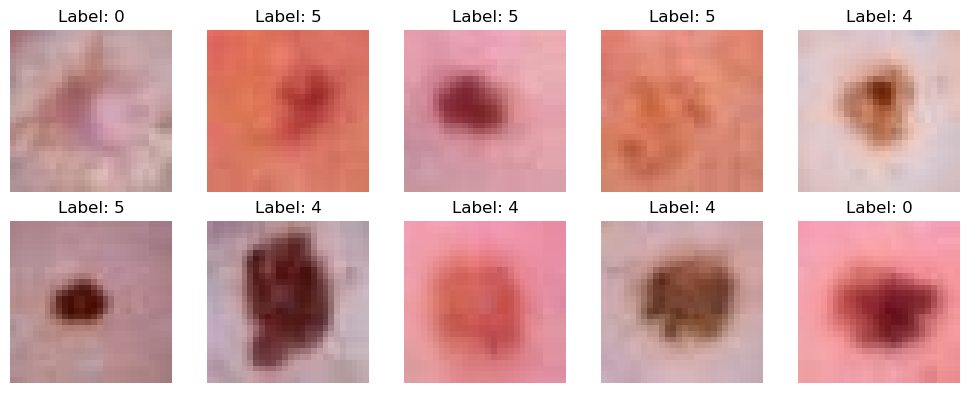

In [31]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap="gray")
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

# DATASET and Normalization

In [32]:
class ImageDataset(Dataset):
    def __init__(self, X, y):
        X = X.astype(np.float32) / 255.0

        # If RGB → convert to grayscale
        if X.ndim == 4 and X.shape[-1] == 3:
            X = X.mean(axis=-1)   # (N, 28, 28)

        self.X = torch.tensor(X).unsqueeze(1)  # (N, 1, 28, 28)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [33]:
x, y = next(iter(train_loader))
print(x.shape)   # MUST be [batch, 1, 28, 28]

torch.Size([64, 1, 28, 28, 3])


In [34]:
train_ds = ImageDataset(X_train, y_train)
val_ds = ImageDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

In [35]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes=7, smoothing=0.1):
        super().__init__()
        self.classes = classes
        self.smoothing = smoothing

    def forward(self, logits, target):
        with torch.no_grad():
            true_dist = torch.zeros_like(logits)
            true_dist.fill_(self.smoothing / (self.classes - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), 1 - self.smoothing)

        return torch.mean(torch.sum(-true_dist * torch.log_softmax(logits, dim=1), dim=1))

# CNN Apply

In [36]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 7)
        )

    def forward(self, x):
        return self.net(x)

# Training

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CNN().to(device)
criterion = LabelSmoothingLoss(classes=7, smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [38]:
best_val_acc = 0

for epoch in range(10):
    model.train()
    train_loss = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            out = model(x)
            preds.extend(out.argmax(1).cpu().numpy())
            targets.extend(y.numpy())

    val_acc = accuracy_score(targets, preds)

    print(f"Epoch {epoch+1} | Loss: {train_loss:.3f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pt")

Epoch 1 | Loss: 193.771 | Val Acc: 0.6690
Epoch 2 | Loss: 192.714 | Val Acc: 0.6690
Epoch 3 | Loss: 192.386 | Val Acc: 0.6690
Epoch 4 | Loss: 191.341 | Val Acc: 0.6690
Epoch 5 | Loss: 190.728 | Val Acc: 0.6690
Epoch 6 | Loss: 190.314 | Val Acc: 0.6700
Epoch 7 | Loss: 189.855 | Val Acc: 0.6690
Epoch 8 | Loss: 189.447 | Val Acc: 0.6720
Epoch 9 | Loss: 189.073 | Val Acc: 0.6919
Epoch 10 | Loss: 188.857 | Val Acc: 0.6580


# Load Best Model

In [39]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
print("Best model loaded")

Best model loaded


# Predict 

In [40]:
def predict(images):
    images = torch.tensor(images, dtype=torch.float32) / 255.0
    images = images.unsqueeze(1).to(device)

    with torch.no_grad():
        outputs = model(images)
        return outputs.argmax(1).cpu().numpy()